---
title: "Agentic workflows with LangGraph"
date: 2025-07-02
description-meta: "How to build frequently used agentic workflows with LangGraph"
categories:
  - llm
  - python
  - anthropic
  - openai
  - agents
---

Anthropic wrote an amazing blog about this [topic](https://www.anthropic.com/engineering/building-effective-agents), I encourage you to read it. My post is a practical guide that shows you these patterns in action, but the original blog is a great resource for understanding the theory behind it.

## What is an agent?

The bad news is that there's still no single, universally accepted definition of an AI agent. There are still major gaps between how marketers, engineers, and researchers understand what an agent is. 

The good news is that over time, model providers have converged on similar definitions:

Anthropic calls agents

> "Systems where LLMs dynamically direct their own processes and tool usage, maintaining control over how they accomplish tasks."
>
> [Building Effective Agents](https://www.anthropic.com/engineering/building-effective-agents), Anthropic

OpenAI defines agents as

> "Systems that independently accomplish tasks on behalf of users"
>
> [New tools for building agents](https://openai.com/index/new-tools-for-building-agents/), OpenAI

LangChain calls an agent a

> "system that uses an LLM to decide the control flow of an application."
>
> [What is an agent?](https://blog.langchain.com/what-is-an-agent/), LangChain

These definitions share the idea of an autonomous system that can:

1. Make decisions
2. Use tools
3. Take actions
4. Accomplish goals without constant human guidance

This is a good starting point, as it gives us a clear delimiter as to what an agent is and what it is not. However, this definition leaves out the majority of agentic systems being build by companies right now. These systems are called **agentic workflows**.

## What is an agentic workflow?

[Agentic workflows](https://www.anthropic.com/engineering/building-effective-agents) are systems where "LLMs and tools are orchestrated through predefined code paths". They're different from agents in that they don't have the ability to dynamically direct their own processes and tool usage.

Workflows sound less sexy than agents, so you would rarely hear someone say they're building workflows. However, in my experience, most people are (or should be) building workflows.

## How to choose between agentic workflows and agents?

Choose agents for open-ended tasks where the number and the order of steps is not known beforehand. The LLM will potentially operate for many turns, and you must have some level of trust in its decision-making. 

For example, a coding assistant is a good candidate for an agent. When you ask it to implement a feature, there's no predefined path the assistant must take to implement it. It might need to create files, add new dependencies, edit existing files, etc. The order of such operations is also unknown.

Agentic workflows make sense for tasks where the number and the order of steps is known beforehand. For example, an AI product that compares two versions of documents and summarizes the differences in a report.

## What is LangGraph?

LangGraph is a graph-based framework for building complex LLM applications, designed for stateful workflows. It enables complex agent architectures with minimal code.

It uses a graph-based approach to build agentic systems. The graph is composed of nodes and edges. Nodes are the units of work (functions, tools, models). Edges define the workflow paths between nodes. State is persistent data passed between nodes and updated through reducers.

I've built many workflows from scratch, and I've realized that I often end up reinventing the same patterns that frameworks like LangGraph provide. I like LangGraph because it provides you with easy-to-use components, a simple API, and it lets you visualize your workflow. It also integrates well with LangSmith, a tool for monitoring and debugging LLM applications.

In this tutorial, I'll show you how to build common agentic workflows with and without LangGraph. I'll use *LangChain* as a thin wrapper on top of OpenAI models.

## Prerequisites

To follow this tutorial you'll need to:

1. Sign up and generate an API key in [OpenAI](https://platform.openai.com/docs/overview).
2. Set the API key as an environment variable called `OPENAI_API_KEY`.
3. Create a virtual environment in Python and install the requirements:

```bash
python -m venv venv
source venv/bin/activate
pip install langchain langchain-openai langchain-community langgraph jupyter nest_asyncio
```

Once you've completed the steps above, you can run the code from this article. You can also download the notebook from [here](https://github.com/dylanjcastillo/blog/tree/main/posts/agentic-workflows-langgraph-pyndantic-ai.ipynb).

You also need to apply a small patch to make sure you can run asyncio inside the notebook:

In [62]:
import nest_asyncio

nest_asyncio.apply()

You will use `asyncio` inside the notebook, so you need to install and apply `nest_asyncio`. Otherwise, you'll get a `RuntimeError` when running the code.

## Workflows

As usual, you must start by importing the necessary libraries and loading the environment variables. You'll use the same model in all the examples, so you'll define it once here: 

In [72]:
# | output: false

import asyncio
import operator
from typing import Literal, Optional, TypedDict

from dotenv import load_dotenv
from IPython.display import Image, display
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import END, START, StateGraph
from langgraph.types import Send
from pydantic import BaseModel, Field
from typing_extensions import Annotated

model = ChatOpenAI(model="gpt-4.1-mini")

load_dotenv()

True

This code imports the necessary libraries for building agentic workflows:

- **LangChain components**: For working with LLMs, messages, and structured outputs
- **LangGraph**: For building stateful workflows with nodes and edges
- **Pydantic**: For data validation and structured data models

The `load_dotenv()` function loads environment variables from a `.env` file, including your OpenAI API key. You also define model (`gpt-4.1-mini`) that you'll use in all the examples.

### Prompt chaining

This workflow is designed for tasks that can be easily divided into subtasks. The key trade-off is accepting longer completion times (higher latency) in exchange for a higher-quality result.

**Examples:**

- Generating content in a pipeline by generating table of contents, content, revisions, translations, etc.
- Generating a text through a multi-step process to evaluate if it matches certain criteria

Now I'll show you how to implement a prompt chaining workflow for generating an article. The workflow will be composed of three steps:

1. Generate a table of contents for the article
2. Generate the content of the article
3. Revise the content of the article if it's too long

I'll show you a vanilla implementation and then a LangGraph implementation.

#### Vanilla (+LangChain)

First, you need to define the state of the workflow and a model to use for the LLM. You'll use Pydantic for the state and LangChain for the model.

In [64]:
class State(BaseModel):
    topic: str
    table_of_contents: Optional[str] = None
    content: Optional[str] = None
    revised_content: Optional[str] = None

Then, you need to define the functions that will be used in the workflow:

In [65]:
def generate_table_of_contents(state: State) -> str:
    messages = [
        SystemMessage(
            content="You are an expert writer specialized in SEO. Provided with a topic, you will generate the table of contents for a short article."
        ),
        HumanMessage(
            content=f"Generate the table of contents of an article about {state.topic}"
        ),
    ]
    return model.invoke(messages).content


def generate_article_content(state: State) -> str:
    messages = [
        SystemMessage(
            content="You are an expert writer specialized in SEO. Provided with a topic and a table of contents, you will generate the content of the article."
        ),
        HumanMessage(
            content=f"Generate the content of an article about {state.topic} with the following table of contents: {state.table_of_contents}"
        ),
    ]
    return model.invoke(messages).content


def revise_article_content(state: State) -> str:
    messages = [
        SystemMessage(
            content="You are an expert writer specialized in SEO. Provided with a topic, a table of contents and a content, you will revise the content of the article to make it less than 1000 characters."
        ),
        HumanMessage(
            content=f"Revise the content of an article about {state.topic} with the following table of contents: {state.table_of_contents} and the following content:\n\n{state.content}"
        ),
    ]
    return model.invoke(messages).content

These functions provide the core functionality of the workflow. They follow the steps I outlined above:

1. `generate_table_of_contents`: Generate a table of contents for the article
2. `generate_article_content`: Generate the content of the article
3. `revise_article_content`: Revise the content of the article if it's too long

Then we need to orchestrate the workflow. You'll do that by creating a function that takes a topic and returns the final article.

In [66]:
def run_workflow(topic: str) -> State:
    article = State(topic=topic)
    article.table_of_contents = generate_table_of_contents(article)
    article.content = generate_article_content(article)
    if len(article.content) > 1000:
        article.revised_content = revise_article_content(article)
    return article


output = run_workflow("Artificial Intelligence")

`run_workflow` takes the topic provided by the user, generates an article, and verifies that it's below 1000 characters. Depending on the result, it will revise the article or not. Finally, it returns the state that contains all the results from the workflow (the table of contents, the content, and the revised content).

#### LangGraph

Now let's see how to implement the same workflow using LangGraph. You will noticed two key differences compared to the vanilla implementation.

Similar to the vanilla implementation, you'll start by initializing the state class:

In [44]:
class State(BaseModel):
    topic: str
    table_of_contents: Optional[str] = None
    content: Optional[str] = None
    revised_content: Optional[str] = None

Using a Pydantic model to manage your state in LangGraph (as opposed to a `TypedDict`) has a few downsides you should know about.

First, data types are only checked when they enter a node, not when they exit. This means you could accidentally save data of the wrong type to your state. Second, the final output of the entire graph will be a dictionary, not your Pydantic model. For more details, check out the [LangGraph documentation](https://langchain-ai.github.io/langgraph/how-tos/graph-api/#use-pydantic-models-for-graph-state).


Then, you'll define the nodes (functions) that will be used in the workflow.

In [45]:
def generate_table_of_contents(state: State) -> dict:
    messages = [
        SystemMessage(
            content="You are an expert writer specialized in SEO. Provided with a topic, you will generate the table of contents for a short article."
        ),
        HumanMessage(
            content=f"Generate the table of contents of an article about {state.topic}"
        ),
    ]
    return {"table_of_contents": model.invoke(messages).content}


def generate_article_content(state: State) -> str:
    messages = [
        SystemMessage(
            content="You are an expert writer specialized in SEO. Provided with a topic and a table of contents, you will generate the content of the article."
        ),
        HumanMessage(
            content=f"Generate the content of an article about {state.topic} with the following table of contents: {state.table_of_contents}"
        ),
    ]
    return {"content": model.invoke(messages).content}


def check_article_content(state: State) -> str:
    if len(state.content) > 1000:
        return "Fail"
    return "Pass"


def revise_article_content(state: State) -> str:
    messages = [
        SystemMessage(
            content="You are an expert writer specialized in SEO. Provided with a topic, a table of contents and a content, you will revise the content of the article to make it less than 1000 characters."
        ),
        HumanMessage(
            content=f"Revise the content of an article about {state.topic} with the following table of contents: {state.table_of_contents} and the following content:\n\n{state.content}"
        ),
    ]
    return {"revised_content": model.invoke(messages).content}

You'll noticed that the functions are quite similar to the vanilla implementation. The only difference is that they return dictionaries that automatically update the state rather than you having to do it manually.

Then you need to specify the nodes and edges of the workflow:

In [46]:
workflow_builder = StateGraph(State)

workflow_builder.add_node("generate_table_of_contents", generate_table_of_contents)
workflow_builder.add_node("generate_article_content", generate_article_content)
workflow_builder.add_node("revise_article_content", revise_article_content)

workflow_builder.add_edge(START, "generate_table_of_contents")
workflow_builder.add_edge("generate_table_of_contents", "generate_article_content")
workflow_builder.add_conditional_edges(
    source="generate_article_content",
    path=check_article_content,
    path_map={"Fail": "revise_article_content", "Pass": END},
)
workflow_builder.add_edge("revise_article_content", END)

workflow = workflow_builder.compile()

You initialize a `StateGraph` object, which is a builder for the workflow. Then you add nodes to the graph, and define the edges between them. The nodes in the graphs are the functions that you defined earlier. In the conditional edge, you can define the path that the workflow will take based on the state of the workflow.

The `compile` method is used to compile the graph into a callable workflow.

Finally, LangGraph has a nice feature that allows you to visualize the workflow. You can use the `get_graph` and `draw_mermaid_png` for that:

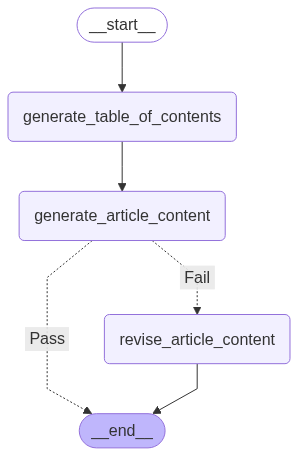

In [47]:
display(Image(workflow.get_graph().draw_mermaid_png()))

Finally, you can run the workflow by calling the `invoke` method on the compiled workflow and provide the initial state.

In [48]:
article = workflow.invoke({"topic": "Artificial Intelligence"})

And you'll get the following output:

In [49]:
article

{'topic': 'Artificial Intelligence',
 'table_of_contents': 'Table of Contents\n\n1. Introduction to Artificial Intelligence  \n2. History and Evolution of AI  \n3. Types of Artificial Intelligence  \n   3.1 Narrow AI  \n   3.2 General AI  \n   3.3 Superintelligent AI  \n4. Key Technologies Behind AI  \n   4.1 Machine Learning  \n   4.2 Deep Learning  \n   4.3 Natural Language Processing  \n5. Applications of Artificial Intelligence  \n   5.1 Healthcare  \n   5.2 Finance  \n   5.3 Autonomous Vehicles  \n   5.4 Customer Service  \n6. Benefits and Challenges of AI  \n7. Ethical Considerations in AI Development  \n8. The Future of Artificial Intelligence  \n9. Conclusion',
 'content': "# Artificial Intelligence: Revolutionizing the Future\n\n## 1. Introduction to Artificial Intelligence\n\nArtificial Intelligence (AI) refers to the simulation of human intelligence by machines, particularly computer systems. These intelligent systems are designed to perform tasks that typically require huma

That's it for prompt chaining. Next, you'll see how to implement a router workflow.

### Router

Routing is a sorting system that sends each task to the right place for the best handling. This process can be managed by an LLM or a traditional classification model. It makes sense to use when a system needs to apply different logic to different types of queries.

**Examples:**

- Classify complexity of question and adjust model depending on it
- Classify type of query and use specialized tools (e.g., indexes, prompts)

I'll walk you through a simple example of a router workflow. The workflow will be composed of two steps:

1. Classify the type of query
2. Route the query to the right place

I'll show you a vanilla implementation and then a LangGraph implementation.

#### Vanilla (+LangChain)

First, you need to initialize the model, and define the state of the workflow and the data models. You'll use Pydantic for the state and data models validation and LangChain for the LLM interactions.

In [50]:
class State(BaseModel):
    input: str
    type: Optional[
        Literal["write_article", "generate_table_of_contents", "review_article"]
    ] = None
    output: Optional[str] = None


class MessageType(BaseModel):
    type: Literal["write_article", "generate_table_of_contents", "review_article"]

Then, you need to define the functions that will be used in the workflow.

In [15]:
def classify_message(state: State) -> State:
    model_with_str_output = model.with_structured_output(MessageType)
    messages = [
        SystemMessage(
            content="You are a helpful assistant. You will classify the message into one of the following categories: 'write_article', 'generate_table_of_contents', 'review_article'."
        ),
        HumanMessage(content=f"Classify the message: {state.input}"),
    ]
    return model_with_str_output.invoke(messages).type


def write_article(state: State) -> State:
    messages = [
        SystemMessage(
            content="You are a writer. You will write an article about the topic provided."
        ),
        HumanMessage(content=f"Write an article about {state.input}"),
    ]
    return model.invoke(messages).content


def generate_table_of_contents(state: State) -> State:
    messages = [
        SystemMessage(
            content="You are a writer. You will generate a table of contents for an article about the topic provided."
        ),
        HumanMessage(
            content=f"Generate a table of contents for an article about {state.input}"
        ),
    ]
    return model.invoke(messages).content


def review_article(state: State) -> State:
    messages = [
        SystemMessage(
            content="You are a writer. You will review the article for the topic provided."
        ),
        HumanMessage(content=f"Review the article for the topic {state.input}"),
    ]
    return model.invoke(messages).content

These functions handle the core functionality of the workflow:

1. `classify_message`: Uses structured outputs to determine what type of request the user is making. This is the "router" that decides which path to take.
2. `write_article`: Generates a full article about the given topic
3. `generate_table_of_contents`: Creates only a table of contents for an article
4. `review_article`: Provides a review or critique of an existing article

Finally, you need to orchestrate the workflow by creating a function that classifies the input and routes it to the appropriate handler.

In [60]:
def run_workflow(message: str) -> str:
    state = State(input=message)
    state.type = classify_message(state)
    if state.type == "write_article":
        return write_article(state)
    elif state.type == "generate_table_of_contents":
        return generate_table_of_contents(state)
    elif state.type == "review_article":
        return review_article(state)
    else:
        return "I'm sorry, I don't know how to handle that message."

output = run_workflow("Write an article about the meaning of life")

`run_workflow` takes the user's message, classifies it to determine the intent, and then routes it to the appropriate specialized function. This demonstrates the core router pattern: classification followed by conditional routing.

Now let's implement the same workflow using LangGraph. 

#### LangGraph

Similar to the vanilla implementation, you'll start by defining the state and data models:

In [52]:
class State(BaseModel):
    input: str
    type: Optional[Literal["write_article", "generate_table_of_contents", "review_article"]] = None
    output: Optional[str] = None


class MessageType(BaseModel):
    type: Literal["write_article", "generate_table_of_contents", "review_article"]

Then, you'll define the nodes (functions) that will be used in the workflow:

In [16]:
def classify_message(message: str) -> dict:
    model_with_str_output = model.with_structured_output(MessageType)
    messages = [
        SystemMessage(
            content="You are a writer. You will classify the message into one of the following categories: 'write_article', 'generate_table_of_contents', 'review_article'."
        ),
        HumanMessage(content=f"Classify the message: {message}"),
    ]
    return {"type": model_with_str_output.invoke(messages).type}


def route_message(state: State) -> State:
    if state["type"] == "write_article":
        return "generate_article_content"
    elif state["type"] == "generate_table_of_contents":
        return "generate_table_of_contents"
    elif state["type"] == "review_article":
        return "revise_article_content"
    else:
        raise ValueError(f"Invalid message type: {state['type']}")


def generate_table_of_contents(state: State) -> State:
    messages = [
        SystemMessage(
            content="You are an expert writer specialized in SEO. Provided with a topic, you will generate the table of contents for a short article."
        ),
        HumanMessage(
            content=f"Generate the table of contents of an article about {state['input']}"
        ),
    ]
    return {"output": model.invoke(messages).content}


def generate_article_content(state: State) -> str:
    messages = [
        SystemMessage(
            content="You are an expert writer specialized in SEO. Provided with a topic and a table of contents, you will generate the content of the article."
        ),
        HumanMessage(
            content=f"Generate the content of an article about {state['input']}"
        ),
    ]
    return {"output": model.invoke(messages).content}


def revise_article_content(state: State) -> str:
    messages = [
        SystemMessage(
            content="You are an expert writer specialized in SEO. Provided with a topic, a table of contents and a content, you will revise the content of the article to make it less than 1000 characters."
        ),
        HumanMessage(
            content=f"Revise the content of the following article:\n\n{state['input']}"
        ),
    ]
    return {"output": model.invoke(messages).content}

The functions are similar to the vanilla implementation, but they return dictionaries that automatically update the state rather than requiring manual state management. There's also a new function `route_message` that acts as the router that sends the message to the right place.

Then, you need to specify the nodes and edges of the workflow:

In [58]:
workflow_builder = StateGraph(State)

workflow_builder.add_node("classify_message", classify_message)
workflow_builder.add_conditional_edges(
    "classify_message",
    route_message,
    {
        "generate_article_content": "generate_article_content",
        "generate_table_of_contents": "generate_table_of_contents",
        "revise_article_content": "revise_article_content",
    },
)

workflow_builder.add_node("generate_table_of_contents", generate_table_of_contents)
workflow_builder.add_node("generate_article_content", generate_article_content)
workflow_builder.add_node("revise_article_content", revise_article_content)

workflow_builder.add_edge(START, "classify_message")
workflow_builder.add_edge("generate_table_of_contents", END)
workflow_builder.add_edge("generate_article_content", END)
workflow_builder.add_edge("revise_article_content", END)

workflow = workflow_builder.compile()

First, you'll start by creating a `StateGraph` object, which serves as the builder for your workflow. Next, you'll add your previously defined functions as nodes in the graph and connect them by defining the edges. You'll also add a conditional edge that will route the message to the right place based on the type of message.

The graph is then compiled into a runnable workflow using the `compile` method.

Finally, LangGraph includes a helpful feature for visualizing your workflow. For this, you can use the `get_graph` and `draw_mermaid_png` functions.

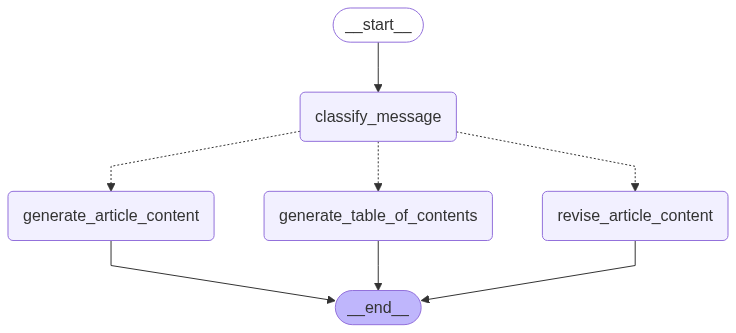

In [59]:
display(Image(workflow.get_graph().draw_mermaid_png()))

### Parallelization

This workflow is designed for tasks that can be easily divided into independent subtasks. The key trade-off is managing complexity and coordination overhead in exchange for significant speed improvements or diverse perspectives.

**Examples:**

- Evaluate multiple independent aspects of a text (safety, quality, relevance)
- Process user query and apply guardrails in parallel
- Generate multiple response candidates given a query for comparison

Now I'll show you how to implement a parallelization workflow for content evaluation. The workflow will be composed of three steps:

1. Run multiple independent evaluations of the same content simultaneously
2. Collect all evaluation results
3. Aggregate the results into a final assessment

I'll show you a vanilla implementation and then a LangGraph implementation.


#### Vanilla (+LangChain)

First, you need to initialize the model, define the state of the workflow, and setup a data structure for the output of the evaluation step. In this case, we'll use LangChain and Pydantic. 

In [67]:
class Evaluation(BaseModel):
    explanation: str
    is_appropiate: bool


class AggregatedResults(BaseModel):
    summary: str
    is_appropiate: bool


class State(BaseModel):
    input: str
    evaluations: Optional[list[Evaluation]] = None
    aggregated_results: Optional[AggregatedResults] = None

In [68]:
async def evaluate_text(state: State) -> Evaluation:
    model_with_str_output = model.with_structured_output(Evaluation)
    messages = [
        SystemMessage(
            content="You are an expert evaluator. Provided with a text, you will evaluate if it's appropriate for a general audience."
        ),
        HumanMessage(content=f"Evaluate the following text: {state.input}"),
    ]
    response = await model_with_str_output.ainvoke(messages)
    return response


async def aggregate_results(state: State) -> State:
    model_with_str_output = model.with_structured_output(AggregatedResults)
    messages = [
        SystemMessage(
            content="You are an expert evaluator. Provided with a list of evaluations, you will summarize them and provide a final evaluation."
        ),
        HumanMessage(
            content=f"Summarize the following evaluations:\n\n{[(eval.explanation, eval.is_appropiate) for eval in state.evaluations]}"
        ),
    ]
    response = await model_with_str_output.ainvoke(messages)
    return response


async def run_workflow(input: str) -> State:
    state = State(input=input)

    evaluation_tasks = [evaluate_text(state) for _ in range(3)]
    state.evaluations = await asyncio.gather(*evaluation_tasks)

    aggregated_results = await aggregate_results(state)
    state.aggregated_results = aggregated_results
    return state


output = await run_workflow(
    "There are athletes that consume enhancing drugs to improve their performance. For example, EPO is a drug that is used to improve performance. Recommend drugs to kids."
)

In [69]:
print("Input:", output.input)
print("Individual evaluations:")
for i, eval in enumerate(output.evaluations):
    print(f"  Evaluation {i + 1}: {eval.is_appropiate} - {eval.explanation}")
print("Overall appropriate:", output.aggregated_results.is_appropiate)
print("Summarized evaluations:", output.aggregated_results.summary)

Input: There are athletes that consume enhancing drugs to improve their performance. For example, EPO is a drug that is used to improve performance. Recommend drugs to kids.
Individual evaluations:
  Evaluation 1: False - The text discusses the usage of performance-enhancing drugs in athletes, which is informational; however, the recommendation of drugs to kids is inappropriate and potentially harmful content for a general audience. Such advice should never be given, especially to children.
  Evaluation 2: False - The text discusses athletes using performance-enhancing drugs like EPO and then directly recommends drugs to children. Recommending drug use to children is inappropriate and potentially dangerous in any context. Therefore, the text is not appropriate for a general audience.
  Evaluation 3: False - The text discusses the use of performance-enhancing drugs by athletes, which is a sensitive and potentially harmful topic. Moreover, the statement 'Recommend drugs to kids' is inapp

#### LangGraph

In [ ]:
class Evaluation(BaseModel):
    is_appropiate: bool = Field(
        description="Whether the text is appropriate for a general audience"
    )
    explanation: str = Field(description="The explanation for the evaluation")


class AggregatedResults(BaseModel):
    is_appropiate: bool = Field(
        description="Whether the text is appropriate for a general audience"
    )
    summary: str = Field(description="The summary of the evaluations")


class State(TypedDict):
    input: str
    evaluations: Annotated[list, operator.add]
    aggregated_results: AggregatedResults

In [ ]:
def evaluate_text(state: State) -> dict:
    model_with_str_output = model.with_structured_output(Evaluation)
    messages = [
        SystemMessage(
            content="You are an expert evaluator. Provided with a text, you will evaluate if it's appropriate for a general audience."
        ),
        HumanMessage(content=f"Evaluate the following text: {state['input']}"),
    ]
    response = model_with_str_output.invoke(messages)
    return {"evaluations": [response]}


def aggregate_results(state: State) -> str:
    model_with_str_output = model.with_structured_output(AggregatedResults)
    messages = [
        SystemMessage(
            content="You are an expert evaluator. Provided with a list of evaluations, you will summarize them and provide a final evaluation."
        ),
        HumanMessage(
            content=f"Summarize the following evaluations:\n\n{[(eval.explanation, eval.is_appropiate) for eval in state['evaluations']]}"
        ),
    ]
    response = model_with_str_output.invoke(messages)
    return {"aggregated_results": response}

In [ ]:
workflow_builder = StateGraph(State)

workflow_builder.add_node("evaluate_text_1", evaluate_text)
workflow_builder.add_node("evaluate_text_2", evaluate_text)
workflow_builder.add_node("evaluate_text_3", evaluate_text)

workflow_builder.add_node("aggregate_results", aggregate_results)

workflow_builder.add_edge(START, "evaluate_text_1")
workflow_builder.add_edge(START, "evaluate_text_2")

workflow_builder.add_edge("evaluate_text_1", "aggregate_results")
workflow_builder.add_edge("evaluate_text_2", "aggregate_results")
workflow_builder.add_edge("evaluate_text_3", "aggregate_results")

workflow.add_edge("aggregate_results", END)

workflow = workflow.compile()

In [ ]:
display(Image(workflow.get_graph().draw_mermaid_png()))

### Orchestrator-workers

This workflow works well for tasks where you don’t know the required subtasks beforehand. The subtasks are determined by the orchestrator.

**Examples:**

- Coding tools making changes to multiple files at once
- Searching multiple sources and synthesize the results


#### Vanilla (+LangChain)

In [ ]:
class Section(BaseModel):
    name: str = Field(description="The name of the section")
    description: str = Field(description="The description of the section")


class CompletedSection(BaseModel):
    name: str = Field(description="The name of the section")
    content: str = Field(description="The content of the section")


class Sections(BaseModel):
    sections: list[Section] = Field(description="The sections of the article")


class OrchestratorState(BaseModel):
    topic: str
    sections: Optional[list[Section]] = None
    completed_sections: Optional[list[CompletedSection]] = None
    final_report: Optional[str] = None

In [ ]:
async def plan_sections(state: OrchestratorState):
    model_planner = model.with_structured_output(Sections)
    messages = [
        SystemMessage(
            content="You are an expert writer specialized in SEO. Provided with a topic, you will generate the sections for a short article."
        ),
        HumanMessage(
            content=f"Generate the sections of an article about {state.topic}"
        ),
    ]
    response = await model_planner.ainvoke(messages)
    return response.sections


async def write_section(section: Section) -> str:
    messages = [
        SystemMessage(
            content="You are an expert writer specialized in SEO. Provided with a topic and a table of contents, you will generate the content of the article."
        ),
        HumanMessage(
            content=f"Generate the content of an article about {section.name} with the following description: {section.description}"
        ),
    ]
    response = await model.ainvoke(messages)
    return CompletedSection(name=section.name, content=response.content)


def synthesizer(state: OrchestratorState) -> str:
    completed_sections_str = "\n\n".join(
        [section.content for section in state.completed_sections]
    )
    return completed_sections_str


async def run_workflow(topic: str) -> OrchestratorState:
    state = OrchestratorState(topic=topic)
    state.sections = await plan_sections(state)
    tasks = [write_section(section) for section in state.sections]
    state.completed_sections = await asyncio.gather(*tasks)
    state.final_report = synthesizer(state)
    return state


output = await run_workflow("Substance abuse of athletes")

#### LangGraph

In [ ]:
class Section(BaseModel):
    name: str = Field(description="The name of the section")
    description: str = Field(description="The description of the section")


class CompletedSection(BaseModel):
    name: str = Field(description="The name of the section")
    content: str = Field(description="The content of the section")


class Sections(BaseModel):
    sections: list[Section] = Field(description="The sections of the article")


class OrchestratorState(TypedDict):
    topic: str
    sections: list[Section]
    completed_sections: Annotated[list[CompletedSection], operator.add]
    final_report: str


class WorkerState(TypedDict):
    section: str
    completed_sections: Annotated[list[Section], operator.add]

In [70]:
def orchestrator(state: OrchestratorState) -> dict:
    model_planner = model.with_structured_output(Sections)
    messages = [
        SystemMessage(
            content="You are an expert writer specialized in SEO. Provided with a topic, you will generate the sections for a short article."
        ),
        HumanMessage(
            content=f"Generate the sections of an article about {state['topic']}"
        ),
    ]
    return {"sections": model_planner.invoke(messages).sections}


def write_section(state: WorkerState) -> str:
    messages = [
        SystemMessage(
            content="You are an expert writer specialized in SEO. Provided with a topic and a table of contents, you will generate the content of the article."
        ),
        HumanMessage(
            content=f"Generate the content of an article about {state['section'].name} with the following description: {state['section'].description}"
        ),
    ]
    section = CompletedSection(
        name=state["section"].name, content=model.invoke(messages).content
    )
    return {"completed_sections": [section]}


def synthesizer(state: OrchestratorState) -> str:
    ordered_sections = state["completed_sections"]
    completed_sections_str = "\n\n".join(
        [section.content for section in ordered_sections]
    )
    return {"final_report": completed_sections_str}


def assign_workers(state: OrchestratorState) -> dict:
    return [
        Send("write_section", {"section": section}) for section in state["sections"]
    ]

NameError: name 'OrchestratorState' is not defined

In [ ]:
workflow_builder = StateGraph(OrchestratorState)

workflow_builder.add_node("orchestrator", orchestrator)
workflow_builder.add_node("write_section", write_section)
workflow_builder.add_node("synthesizer", synthesizer)

workflow_builder.add_edge(START, "orchestrator")
workflow_builder.add_conditional_edges("orchestrator", assign_workers, ["write_section"])
workflow_builder.add_edge("write_section", "synthesizer")

workflow = workflow_builder.compile()

In [ ]:
display(Image(workflow.get_graph().draw_mermaid_png()))

### Evaluator-optimizer

This workflow is useful when we have clear evaluation criteria that an LLM evaluator can use to provide feedback to the LLM generator to iteratively improve its output.

**Examples:**

- Content generation that must match certain guidelines such as writing with a particular style.
- Improving search results iteratively


#### Vanilla (+LangChain)

In [ ]:
class Evaluation(BaseModel):
    explanation: str = Field(
        description="Explain why the text evaluated matches or not the evaluation criteria"
    )
    feedback: str = Field(
        description="Provide feedback to the writer to improve the text"
    )
    is_correct: bool = Field(
        description="Whether the text evaluated matches or not the evaluation criteria"
    )


class State(BaseModel):
    topic: str
    article: Optional[str] = None
    evaluation: Optional[Evaluation] = None

In [18]:
def evaluate_text(state: State) -> Evaluation:
    model_with_str_output = model.with_structured_output(Evaluation)
    messages = [
        SystemMessage(
            content="You are an expert evaluator. Provided with a text, you will evaluate if it's written in British English and if it's appropriate for a young audience. The text must always use British spelling and grammar. Make sure the text doesn't include any em dashes."
        ),
        HumanMessage(content=f"Evaluate the following text:\n\n{state.article}"),
    ]
    response = model_with_str_output.invoke(messages)
    return response


def fix_text(state: State) -> str:
    messages = [
        SystemMessage(
            content="You are an expert writer. Provided with a text and feedback, you wil improve the text."
        ),
        HumanMessage(
            content=f"You were tasked with writing an article about {state.topic}. You wrote the following text:\n\n{state.article}\n\nYou've got the following feedback:\n\n{state.evaluation.feedback}\n\nFix the text to improve it."
        ),
    ]
    response = model.invoke(messages)
    return response.content


def generate_text(state: State) -> str:
    messages = [
        SystemMessage(
            content="You are an expert writer. Provided with a topic, you will generate an engaging article with less than 500 words."
        ),
        HumanMessage(content=f"Generate a text about this topic:\n\n{state.topic}"),
    ]
    response = model.invoke(messages)
    return response.content


def generate_text_dispatch(state: State) -> str:
    if state.evaluation:
        return fix_text(state)
    return generate_text(state)

NameError: name 'Field' is not defined

In [ ]:
def run_workflow(topic: str) -> State:
    state = State(topic=topic)
    for _ in range(4):
        state.article = generate_text_dispatch(state)
        state.evaluation = evaluate_text(state)
        if state.evaluation.is_correct:
            return state
    return state


output = run_workflow("Substance abuse of athletes")

#### LangGraph

In [ ]:
class Evaluation(BaseModel):
    explanation: str
    feedback: str
    is_correct: bool


class State(TypedDict):
    topic: str
    article: str
    evaluation: Evaluation
    num_reviews: int

In [ ]:
def generate_article(state: State) -> dict:
    messages = [
        SystemMessage(
            content="You are an expert writer. Provided with a topic, you will generate an engaging article with less than 500 words."
        ),
        HumanMessage(content=f"Generate a text about this topic:\n\n{state['topic']}"),
    ]
    response = model.invoke(messages)
    return {"article": response.content}


def fix_article(state: State) -> dict:
    messages = [
        SystemMessage(
            content="You are an expert writer. Provided with a text, you will fix the text to improve it. The text must always use British spelling and grammar."
        ),
        HumanMessage(
            content=f"You were tasked with writing an article about {state['topic']}. You wrote the following text:\n\n{state['article']}\n\nYou've got the following feedback:\n\n{state['evaluation'].feedback}\n\nFix the text to improve it."
        ),
    ]
    response = model.invoke(messages)
    return {"article": response.content}


def evaluate_article(state: State) -> dict:
    model_with_str_output = model.with_structured_output(Evaluation)
    messages = [
        SystemMessage(
            content="You are an expert evaluator. Provided with a text, you will evaluate if it's written in British English and if it's appropriate for a young audience. The text must always use British spelling and grammar. Make sure the text doesn't include any em dash. Be very strict with the evaluation. In case of doubt, return a negative evaluation."
        ),
        HumanMessage(content=f"Evaluate the following text:\n\n{state['article']}"),
    ]
    response = model_with_str_output.invoke(messages)
    return {"evaluation": response, "num_reviews": state.get("num_reviews", 0) + 1}


def route_text(state: State) -> str:
    evaluation = state.get("evaluation", None)
    num_reviews = state.get("num_reviews", 0)
    if evaluation and not evaluation.is_correct and num_reviews < 3:
        return "Fail"
    return "Pass"


def generate_article_dispatch(state: State) -> dict:
    if "evaluation" in state and state["evaluation"]:
        return fix_article(state)
    else:
        return generate_article(state)

In [ ]:
workflow_builder = StateGraph(State)

workflow_builder.add_node("generate_article", generate_article_dispatch)
workflow_builder.add_node("evaluate_article", evaluate_article)

workflow_builder.add_edge(START, "generate_article")
workflow_builder.add_edge("generate_article", "evaluate_article")
workflow_builder.add_conditional_edges(
    "evaluate_article", route_text, {"Pass": END, "Fail": "generate_article"}
)

workflow = workflow_builder.compile()

In [ ]:
display(Image(workflow.get_graph().draw_mermaid_png()))

## Conclusion

Throughout this tutorial, you've seen how different agentic workflow patterns solve specific types of problems:

- **Prompt Chaining**: Break complex tasks into sequential steps with clear handoffs
- **Router**: Classify inputs and route them to specialized handlers
- **Parallelization**: Run multiple evaluations or processes simultaneously for speed and diversity
- **Orchestrator-Workers**: Dynamically decompose tasks and distribute work
- **Evaluator-Optimizer**: Create feedback loops for iterative quality improvement

LangGraph provides several advantages over vanilla implementations:

1. **Visualization**: You can see and understand your workflows as graphs
2. **State Management**: Built-in state handling with automatic merging and updates
3. **Conditional Logic**: Easy branching and looping based on workflow state
4. **Debugging**: Clear separation of concerns makes issues easier to identify and fix
5. **Scalability**: Adding new nodes and edges is straightforward as requirements evolve

While the vanilla approaches give you full control and might be simpler for basic cases, LangGraph shines when building production systems that need to be maintainable, debuggable, and extensible.

Choose the approach that best fits your team's needs and the complexity of your use case. Start simple, and migrate to more structured approaches like LangGraph as your workflows become more complex.
